# Google Cloud & Youtube-8M Video Understanding Challenge


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

frame_level
label_names.csv
sample_submission.csv
video_level



In [2]:
import tensorflow as tf
import numpy as np
from IPython.display import YouTubeVideo


video_lvl_record = "../input/video_level/train-1.tfrecord"
frame_lvl_record = "../input/frame_level/train-1.tfrecord"

In [3]:
vid_ids = []
labels = []
mean_rgb = []
mean_audio = []

for example in tf.python_io.tf_record_iterator(video_lvl_record):
    tf_example = tf.train.Example.FromString(example)

    vid_ids.append(tf_example.features.feature['video_id'].bytes_list.value[0].decode(encoding='UTF-8'))
    labels.append(tf_example.features.feature['labels'].int64_list.value)
    mean_rgb.append(tf_example.features.feature['mean_rgb'].float_list.value)
    mean_audio.append(tf_example.features.feature['mean_audio'].float_list.value)

In [4]:
print('Number of videos in this tfrecord: ',len(mean_rgb))
print('First video feature length',len(mean_rgb[0]))
print('First 20 features of the first youtube video (',vid_ids[0],')')
print(mean_rgb[0][:20])

Number of videos in this tfrecord:  1178
First video feature length 1024
First 20 features of the first youtube video ( -1VnJGJ6c2U )
[-0.012599143199622631, 0.3304528594017029, -0.29592639207839966, -0.36568647623062134, -0.8026612401008606, 0.21889519691467285, 0.35500529408454895, -0.2260688841342926, -0.5064732432365417, 0.07810844480991364, 0.41307374835014343, 0.49774065613746643, -0.9868044853210449, -0.3064488470554352, -0.4073866307735443, -0.18115352094173431, 0.788472592830658, 0.5324258208274841, 0.1439713090658188, -0.4460664391517639]


In [5]:
def play_one_vid(record_name, video_index):
    return vid_ids[video_index]
    

In [6]:
print('mean_audio has length of: ')
print([len(x) for x in mean_audio][:5])
print('mean_rgb has length of: ')
print([len(x) for x in mean_rgb][:5])

mean_audio has length of: 
[128, 128, 128, 128, 128]
mean_rgb has length of: 
[1024, 1024, 1024, 1024, 1024]


In [7]:
# now, let's read the frame-level data
# due to execution time, i'm only going to read the first video

feat_rgb = []
feat_audio = []

for example in tf.python_io.tf_record_iterator(frame_lvl_record):        
    tf_seq_example = tf.train.SequenceExample.FromString(example)
    n_frames = len(tf_seq_example.feature_lists.feature_list['audio'].feature)
    sess = tf.InteractiveSession()
    rgb_frame = []
    audio_frame = []
    # iterate through frames
    for i in range(n_frames):
        rgb_frame.append(tf.cast(tf.decode_raw(
                tf_seq_example.feature_lists.feature_list['rgb'].feature[i].bytes_list.value[0],tf.uint8)
                       ,tf.float32).eval())
        audio_frame.append(tf.cast(tf.decode_raw(
                tf_seq_example.feature_lists.feature_list['audio'].feature[i].bytes_list.value[0],tf.uint8)
                       ,tf.float32).eval())
        
        
    sess.close()
    feat_rgb.append(rgb_frame)
    feat_audio.append(audio_frame)
    break

In [8]:
print('The first video has %d frames' %len(feat_rgb[0]))

The first video has 161 frames


In [9]:
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE
import numpy as np

# now let's explore a little on the labels
Find the most commonly appeared label in this record:

In [10]:
n=10
from collections import Counter
label_mapping = pd.Series.from_csv('../input/label_names.csv',header=0).to_dict()

top_n = Counter([item for sublist in labels for item in sublist]).most_common(n)
top_n_labels = [int(i[0]) for i in top_n]
top_n_label_names = [label_mapping[x] for x in top_n_labels]
top_n_label_names

['Cosmetics',
 'Games',
 'Car',
 'Vehicle',
 'Animal',
 'Animation',
 'Diving',
 'Video game',
 'Dance',
 'Music video']

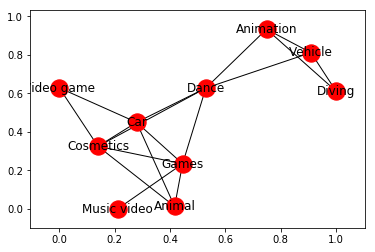

In [11]:
import networkx as nx
from itertools import combinations

G=nx.Graph()

G.clear()
for list_of_nodes in labels:
    filtered_nodes = set(list_of_nodes).intersection(set(top_n_labels))  
    for node1,node2 in list(combinations(filtered_nodes,2)): 
        node1_name = label_mapping[node1]
        node2_name = label_mapping[node2]
        G.add_node(node1_name)
        G.add_node(node2_name)
        G.add_edge(node1_name, node2_name)

nx.draw_networkx(G)

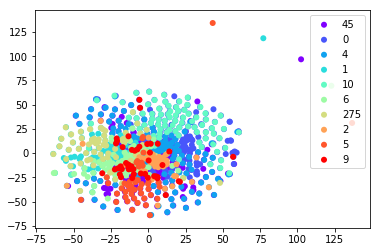

In [12]:
colors = plt.cm.rainbow(np.linspace(0, 1, n))
mean_rgb_top_n = []
labels_for_tsne = []
# filtering mean_rgb so it only contains top n labels
for idx, list_of_nodes in enumerate(labels):
    for node in list_of_nodes:
        if node in top_n_labels:
            mean_rgb_top_n.append(mean_rgb[idx])
            labels_for_tsne.append(node)


X_embedded = TSNE(n_components=2, random_state=0).fit_transform(mean_rgb_top_n) 


fig = plt.figure()
ax = fig.add_subplot(111)

handles = []
for indx, color in enumerate(colors):
    this_label = top_n_labels[indx]
    X_embedded_filtered = X_embedded[np.array([x==this_label for x in labels_for_tsne])]
    handles.append(ax.scatter(X_embedded_filtered[:, 0], X_embedded_filtered[:, 1], c=color, marker="o",edgecolor='none'))

ax.legend(handles, top_n_labels)

plt.show()